# Above ground biomass data

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layer
- Querying the data layers
    - Point query
    - Raster query
- References

## Overview

Above ground biomass (AGB) data that is generated by using IBM tuned AI Models models along with data that is required to create AGB predictions.



## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [19]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import datetime
import configparser
import pandas as pd
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from PIL import Image as Image
from IPython.display import Image as Img


def now():
    return datetime.datetime.utcnow().isoformat()


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2025-02-18T04:44:58.920385
Imports initialized.


## Get authentication token

In [21]:
config = configparser.RawConfigParser()
config.read("../../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3
)

2025-02-18 10:15:02 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-02-18 10:15:02 - paw - INFO - Legacy Environment is False
2025-02-18 10:15:02 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-02-18 10:15:04 - paw - INFO - Authentication success.
2025-02-18 10:15:04 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layer

To get started, we’ll first explore the **catalog sub-module** of the `ibmpairs` library. This will allow us to retrieve the **dataset_id** and the associated **datalayer(s)** that comprise the dataset we’re interested in querying. By identifying the correct dataset and its structure, we can ensure that we are working with the right data for our analysis. 

Let’s walk through this process step by step.

In [24]:
# search for datasets by name
filter_catalogue_search_df = catalog.search("Above ground biomass data")
filter_catalogue_search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_description_long,data_layer_level,data_layer_type,data_layer_unit,data_set_id,data_set_name,data_set_description_short,data_set_description_long
0,38,38000,above ground biomass,,Above ground biomass inference model output in...,21,Raster,,38,Above ground biomass data,Above ground biomass data generated using IBM ...,Above ground biomass (AGB) data that is genera...
1,38,38002,tree species above ground biomass natural,,Tree species specific above ground biomass inf...,21,Raster,,38,Above ground biomass data,Above ground biomass data generated using IBM ...,Above ground biomass (AGB) data that is genera...
2,38,38003,tree species above ground biomass provoked,,Tree species specific above ground biomass inf...,21,Raster,,38,Above ground biomass data,Above ground biomass data generated using IBM ...,Above ground biomass (AGB) data that is genera...
3,38,38001,canopy height,,Canopy Height in meters generated as the outpu...,21,Raster,,38,Above ground biomass data,Above ground biomass data generated using IBM ...,Above ground biomass (AGB) data that is genera...


As shown above, the Data Set with ID 38 contains multiple Data Layers with IDs - 38000, 38001, 38002, 38003. To gain a better understanding of the Data Set, including its geospatial and temporal coverage, as well as other relevant metadata, we can perform additional queries in the catalog submodule, as outlined in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers

### Point query
Next, let us make a point query for location in the Amazon rainforest, specifically in Brazil to observe above ground biomass data.

In [4]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {
                "type": "raster", 
                "id": "38000"
            },
            {
                "type": "raster", 
                "id": "38001"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                -9.9196, -73.9523
            ]  # point in a region in Brazil
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2022-01-01T00:00:00Z", 
                    "end": "2022-01-02T00:00:00Z"
                }
            ]
        }
    },
    client=EI_client_v3
)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()

# Convert the timestamp to a human readable format as datetime
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce", utc=True)
point_df["datetime"] = point_df["datetime"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df = point_df.drop(columns=["timestamp"])

# The datetime column will be placed in the middle of the dataFrame, while keeping all other columns in their original order.
datetime_col = "datetime"
columns = point_df.columns.tolist()
columns.remove(datetime_col)
middle_index = len(columns) // 2
columns.insert(middle_index, datetime_col)

point_df = point_df[columns]
point_df

2025-01-23 18:10:15 - paw - INFO - TASK: submit STARTING.
2025-01-23 18:10:17 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,datetime,longitude,latitude,value
0,38000,above ground biomass,Above ground biomass data,2022-01-01T00:00:00Z,-73.9523,-9.9196,116.000000
1,38001,canopy height,Above ground biomass data,2022-01-01T00:00:00Z,-73.9523,-9.9196,18.000000


### Raster query
Next, let's perform a raster query pointing to a location in the Amazon rainforest, specifically in Brazil to observe above ground biomass data.

In [5]:
AGBResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Above ground biomass data for region in southern America",
        "spatial": {
            "type": "square",
            "coordinates": [
                -9.9196, -73.9523,
                -9.8354,-73.8460
            ] # point in a region in Brazil
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2022-01-01T00:00:00Z", 
                    "end": "2022-01-01T23:00:00Z"
                }
            ]
        },
        "layers": [
            {
                "type": "raster", 
                "id": "38000", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "38001", 
                "output": True
            }
        ]
    },
    client=EI_client_v3
)

2025-01-23 18:10:19 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-23 18:10:20 - paw - INFO - The query was successfully submitted with the id: 1737633600_02420585.
2025-01-23 18:10:21 - paw - INFO - The query 1737633600_02420585 has the status Queued.
2025-01-23 18:10:54 - paw - INFO - The query 1737633600_02420585 has the status Succeeded.
2025-01-23 18:10:54 - paw - INFO - The query 1737633600_02420585 was successful after checking the status.
2025-01-23 18:11:25 - paw - INFO - The query 1737633600_02420585 has the status Succeeded.
2025-01-23 18:11:25 - paw - INFO - The query 1737633600_02420585 was successful after checking the status.
2025-01-23 18:11:25 - paw - INFO - The query download folder is set to the path /Users/raunakbhansali/Documents/GitHub/Environmental-Intelligence-internal/geospatial/samples/v3/datasets/above_ground_biomass/download/.
2025-01-23 18:11:29 - paw - INFO - The query 1737633600_02420585 is a zip.
2025-01-23 18:11:29 - paw - INFO 

In [6]:
colormap_dict = {
    "above_ground_biomass": "viridis",
    "canopy_height": "cividis",
}

def choose_colormap(file_name):
    if "data-above" in file_name.lower():
        return colormap_dict["above_ground_biomass"]
    elif "data-canopy" in file_name.lower():
        return colormap_dict["canopy_height"]
    else:
        return "terrain"  # Default colormap if no match

AGBResult_file_list = AGBResult.list_files()
output_image_array = []
for file in AGBResult_file_list:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        boundingBox = fileparms["boundingBox"]
        pixelStatistics = fileparms["rasterStatistics"]
        # Check if pixelMin and pixelMax are valid (not None)
        if pixelStatistics is not None:
            myextent = [
                boundingBox["minLongitude"],
                boundingBox["maxLongitude"],
                boundingBox["minLatitude"],
                boundingBox["maxLatitude"],
            ]
            arrayGMTED = np.array(Image.open(file))
            mask = arrayGMTED == -9999

            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayGMTED, mask)
            plt.figure(
                figsize=(20, 9), dpi=80
            )  # Sets the size and resolution of the plot
            cmap = choose_colormap(file)
            plt.imshow(
                    masked_array,
                    cmap=cmap,
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            
            # Loads the raster data and sets the colormap
            plt.colorbar()  # Adds the color bar
            plt.title(" " + os.path.basename(file))
            # Create a unique output image path using the file name
            output_image_path = os.path.basename(file) + "_image.png"
            output_image_array.append(output_image_path)

            # Save the figure
            plt.savefig(output_image_path, bbox_inches="tight")
            plt.close()

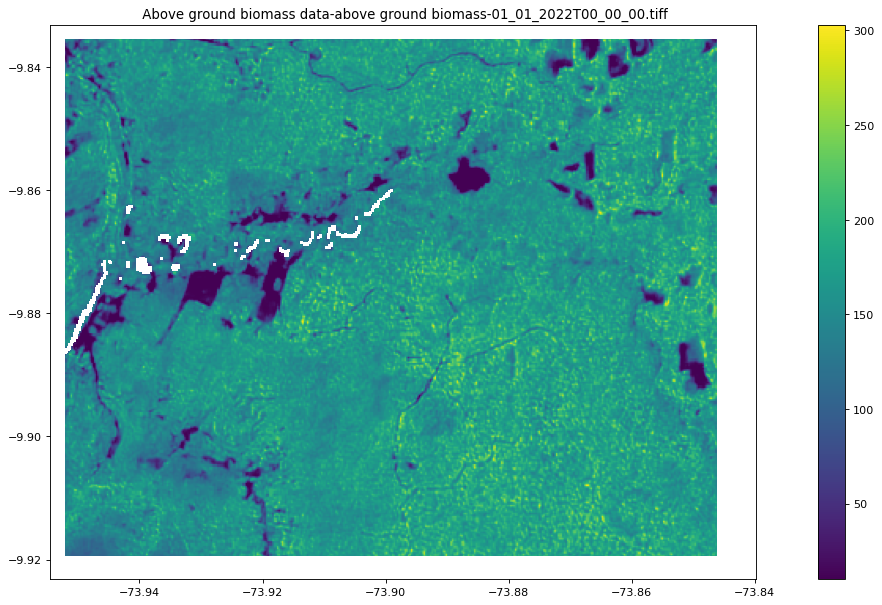

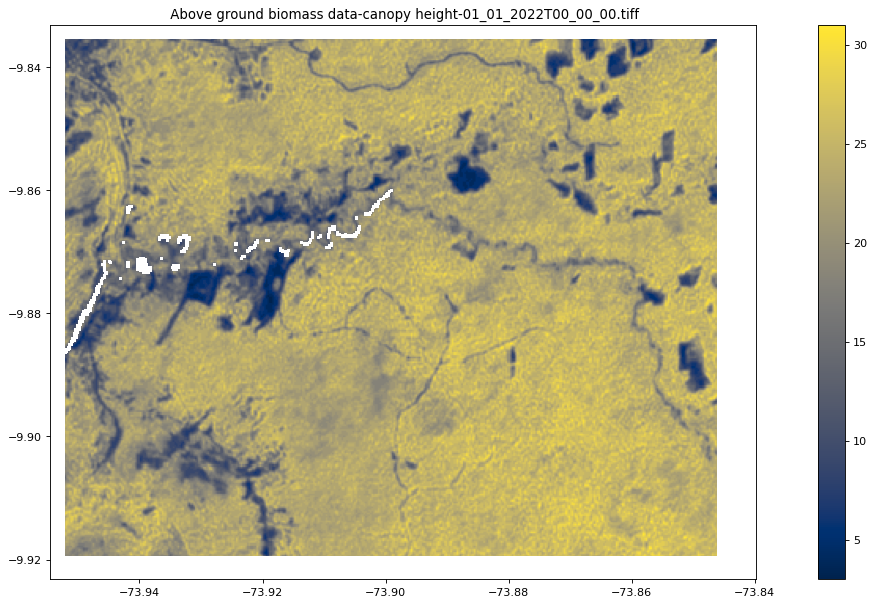

In [8]:
for output_image in output_image_array:
    # display the raster images
    display(Img(output_image, width=600, height=300))

The raster images above represent different aspects of vegetation and forest structure, specifically focused on above ground biomass and canopy height.

**Note:** Users must specifically use `version 4` when working with the AGB data to ensure compatibility and accuracy.

### References
- https://lpvs.gsfc.nasa.gov/AGB/AGB_home.html
- https://www.eoportal.org/other-space-activities/above-ground-biomass#copernicussentinel2